## Reading all the art gallery locations from the csv file

In [98]:
import csv
import pandas as pd

def read_csv_headers(file_path):
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file)
        headers = next(reader)
    return headers

file_path = 'ART_GALLERY_20240726.csv'
headers = read_csv_headers(file_path)
print(headers)

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Define the list of ZIP codes to filter
zip_codes = [
    10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009, 10010, 10011, 10012, 10013, 10014, 10016, 10017, 10018,
    10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10029, 10030, 10031, 10032, 10033, 10034, 10035,
    10036, 10038, 10039, 10040, 10041, 10044, 10047, 10048, 10128
]

# Filter the DataFrame to include only rows with ZIP codes in the list
df_filtered = df[df['ZIP'].isin(zip_codes)]

print(df_filtered.head())



['the_geom', 'NAME', 'TEL', 'URL', 'ADDRESS1', 'ADDRESS2', 'CITY', 'ZIP']
                                        the_geom  \
0  POINT (-73.96273074561996 40.773800871637576)   
1    POINT (-74.0093857886298 40.71646850931738)   
2    POINT (-73.96435178145856 40.7740008522409)   
3   POINT (-74.00389261044238 40.74958540084406)   
4   POINT (-74.00176389614576 40.72290742771331)   

                                                NAME             TEL  \
0                          O'reilly William & Co Ltd  (212) 396-1822   
1  Organization of Independent Artists - Gallery 402  (212) 219-9213   
2                                       Owen Gallery  (212) 879-2415   
3                                   P P O W Gallerie  (212) 647-1044   
4                                        P P O W Inc  (212) 941-8642   

                                                 URL       ADDRESS1 ADDRESS2  \
0  http://www.nyc.com/arts__attractions/oreilly_w...   52 E 76th St      NaN   
1  http://www.nonpro

## Every art gallery in NYC

In [99]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import folium

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the 'the_geom' column to Shapely geometries
df['geometry'] = df['the_geom'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Create a folium map centered around the mean coordinates of the points
mean_lat = gdf.geometry.y.mean()
mean_lon = gdf.geometry.x.mean()
m = folium.Map(location=[mean_lat, mean_lon - 0.05], zoom_start=12, tiles='CartoDB positron', min_zoom=11)

# Set bounds to limit the pan
bounds = gdf.total_bounds
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# Add the points to the folium map
for idx, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

# Display the folium map in the notebook
m


## Gradient the dots based on their proximity with other dots.

In [100]:
# Import geopy for distance calculation
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Function to calculate color gradient
def get_color_gradient(value, min_value, max_value):
    norm_value = (value - min_value) / (max_value - min_value)
    return plt.cm.rainbow(norm_value)  # Use the 'rainbow' colormap for red to blue gradient

# Calculate the total distances for all points to find min and max
total_distances = []
for idx, row in gdf.iterrows():
    point = (row.geometry.y, row.geometry.x)
    distances, indices = tree.query(point, k=6)
    total_distance = sum(geodesic(point, (gdf.iloc[neighbor_idx].geometry.y, gdf.iloc[neighbor_idx].geometry.x)).miles for neighbor_idx in indices[1:])
    total_distances.append(total_distance)

min_distance = min(total_distances)
max_distance = max(total_distances)

# Iterate over each point and find the 5 nearest neighbors
for idx, row in gdf.iterrows():
    point = (row.geometry.y, row.geometry.x)
    distances, indices = tree.query(point, k=6)  # k=6 because the point itself is included

    # Calculate the sum of distances to the 5 nearest neighbors
    total_distance = sum(geodesic(point, (gdf.iloc[neighbor_idx].geometry.y, gdf.iloc[neighbor_idx].geometry.x)).miles for neighbor_idx in indices[1:])

    # Determine the color based on the total distance
    color = get_color_gradient(total_distance, min_distance, max_distance)
    color_hex = matplotlib.colors.rgb2hex(plt.cm.rainbow(total_distance))

    # Add lines to the 5 nearest neighbors with 0.3 opacity black lines
    for neighbor_idx in indices[1:]:
        neighbor_point = (gdf.iloc[neighbor_idx].geometry.y, gdf.iloc[neighbor_idx].geometry.x)
        folium.PolyLine(
            locations=[point, neighbor_point],
            color='black',
            weight=1,
            opacity=0.1
        ).add_to(m)

    # Add the dot with the gradient color
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=1,  # Turn the circles into dots
        color=color_hex,
        fill=True,
        fill_color=color_hex
    ).add_to(m)

# Set the basemap opacity to 0.6
m.get_root().html.add_child(folium.Element('<style>div.leaflet-tile-pane { opacity: 0.5; }</style>'))

# Display the folium map in the notebook
m


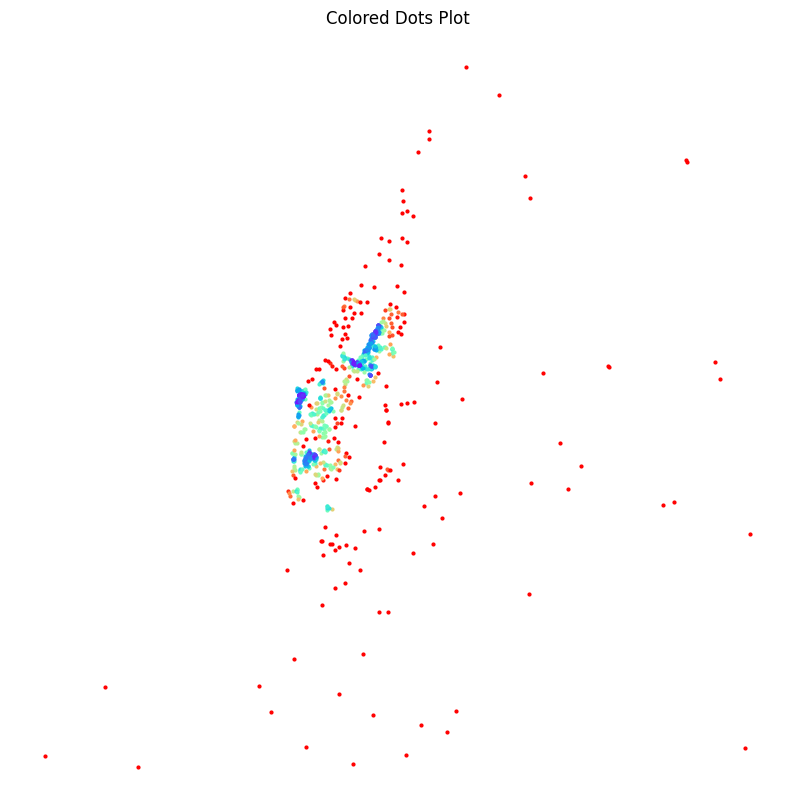

In [101]:
import matplotlib.pyplot as plt

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the colored dots
for idx, row in gdf.iterrows():
    point = (row.geometry.y, row.geometry.x)
    distances, indices = tree.query(point, k=6)
    total_distance = sum(geodesic(point, (gdf.iloc[neighbor_idx].geometry.y, gdf.iloc[neighbor_idx].geometry.x)).miles for neighbor_idx in indices[1:])
    color = get_color_gradient(total_distance, min_distance, max_distance)
    color_hex = matplotlib.colors.rgb2hex(plt.cm.rainbow(total_distance))
    
    ax.plot(row.geometry.x, row.geometry.y, 'o', color=color_hex, markersize=2)

# Set the title and remove the axes
plt.title('Colored Dots Plot')
ax.set_axis_off()

# Save the plot to a variable
plot1 = fig

# Display the plot
plt.show()


## Reading PLUTO data

In [86]:
import geopandas as gpd

# Read the MapPLUTO shapefile
mappluto_gdf = gpd.read_file('nyc_mappluto_24v1_1_shp/MapPLUTO.shp')

# Display the headers of the GeoDataFrame
mappluto_gdf.columns


Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

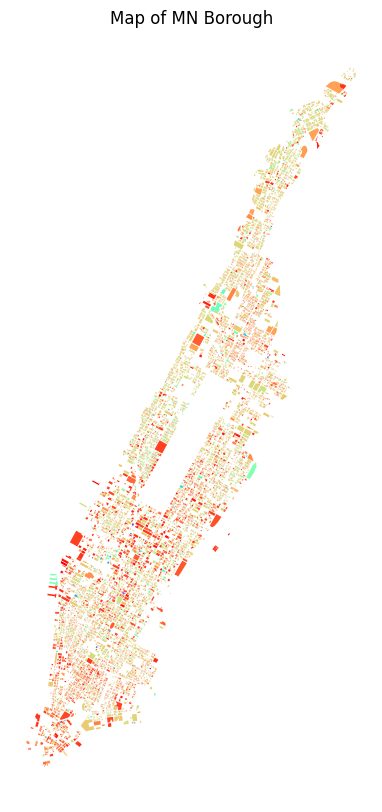

In [109]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Filter out the data where Borough doesn't equal 'MN'
filtered_gdf = mappluto_gdf[mappluto_gdf['Borough'] == 'MN']

# Filter out YearAlter1 data before 1900
filtered_gdf = filtered_gdf[filtered_gdf['YearAlter1'] >= 1900]

# Normalize the YearAlter1 column for color mapping, excluding zero values
filtered_years = filtered_gdf[filtered_gdf['YearAlter1'] != 0]['YearAlter1']
norm = plt.Normalize(filtered_years.min(), filtered_years.max())
cmap = plt.cm.rainbow  # Change the colormap to rainbow for a gradient effect

# Plot the geometry column using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
filtered_gdf.plot(ax=ax, color=filtered_gdf['YearAlter1'].apply(lambda x: mcolors.rgb2hex(cmap(norm(x)))), linewidth=0.5)
plt.title('Map of MN Borough')
ax.set_axis_off()  # Remove the coordinate axes

# Save the plot to a variable
plot2 = fig

# Display the plot
plt.show()


In [108]:
import folium
from folium import features
import io
from PIL import Image

# Create a base map
base_map = folium.Map(location=[filtered_gdf['Latitude'].mean(), filtered_gdf['Longitude'].mean()], zoom_start=12)

# Convert plot2 (matplotlib plot) to an image and overlay it on the folium map
buf = io.BytesIO()
plot2.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
img = Image.open(buf)

# Convert the image to a folium image overlay
img_overlay = folium.raster_layers.ImageOverlay(image=buf, bounds=[[filtered_gdf['Latitude'].min(), filtered_gdf['Longitude'].min()],
                                                       [filtered_gdf['Latitude'].max(), filtered_gdf['Longitude'].max()]],
                                    opacity=0.6, interactive=True, cross_origin=False, zindex=1)

# Add the image overlay to the base map
img_overlay.add_to(base_map)

# Save the combined map to a variable
plot3 = base_map

# Display the combined map
plot3


TypeError: Object of type BytesIO is not JSON serializable